In [1]:

from google.colab import drive
drive.mount('/content/gdrive') # You can either use your drive or work directly on colab with temporary import

Mounted at /content/gdrive


In [2]:
#@title Run Me Please
!pip -q install pydot_ng
!pip -q install graphviz
!apt install graphviz > /dev/null

from __future__ import absolute_import, division, print_function

import tensorflow as tf
# import tensorflow.contrib.eager as tfe
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
%matplotlib inline
from tensorflow import keras
# try:
#   tf.enable_eager_execution()
#   print('Running in Eager mode.')
# except ValueError:
#   print('Already running in Eager mode')

from __future__ import print_function, division
from builtins import range, input
from keras.layers import Input, Lambda, Dense, Flatten, Dropout, GlobalAveragePooling2D
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.resnet50  import ResNet50
from keras.applications.inception_v3 import InceptionV3
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.vis_utils import plot_model
from tensorflow.keras.layers import Flatten
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
from time import time
import pickle
from sklearn.utils import shuffle
import pandas as pd


In [3]:
# Load pickled data

# TODO: Fill this in based on where you saved the training and testing data
# If you have a folder in your Drive named traffic-signs-data you do so, else change directory

training_file = '/content/gdrive/My Drive/traffic-signs-data/train.p'
validation_file= '/content/gdrive/My Drive/traffic-signs-data/valid.p'
testing_file = '/content/gdrive/My Drive/traffic-signs-data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

In [4]:
signs = []
signnames = pd.read_csv('/content/gdrive/My Drive/traffic-signs-data/signnames.csv', delimiter=',', header=0)
for row in range(signnames.shape[0]):
     signs.append(signnames.iloc[row, 1])    
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

In [5]:
#  Number of training examples
n_train = X_train.shape[0]

# Number of validation examples
n_validation = X_valid.shape[0]

# Number of test examples.
n_test = X_test.shape[0]

#  What's the shape of a traffic sign image?
image_shape = X_test[0].shape

#  How many unique classes/labels there are in the dataset.
n_classes = len(np.unique(y_train))


print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Number of valid examples =", n_validation)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)


Number of training examples = 34799
Number of testing examples = 12630
Number of valid examples = 4410
Image data shape = (32, 32, 3)
Number of classes = 43


In [6]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_test = label_encoder.fit_transform(y_test)
y_train = label_encoder.fit_transform(y_train)
y_valid = label_encoder.fit_transform(y_valid)
y_train

array([41, 41, 41, ..., 25, 25, 25])

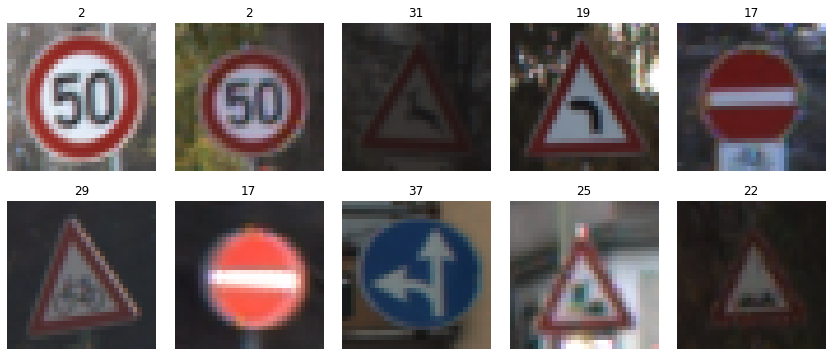

In [7]:
import random
### Data exploration visualization code goes here.
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline
def show_images(X,Y,r,c):
  fig, axs = plt.subplots(r,c, figsize=(15, 6))
  fig.subplots_adjust(hspace = .2, wspace=.001)
  axs = axs.ravel()
  for i in range(10): # if rows = 2 and columns = 5 i should take 10 values
      index = random.randint(0, len(X))
      image = X[index]
      axs[i].axis('off')
      axs[i].imshow(image)
      axs[i].set_title(Y[index])
  plt.show()    

# show image of 10 random data points
rows = 2
columns = 5
show_images (X_train,y_train, rows, columns)


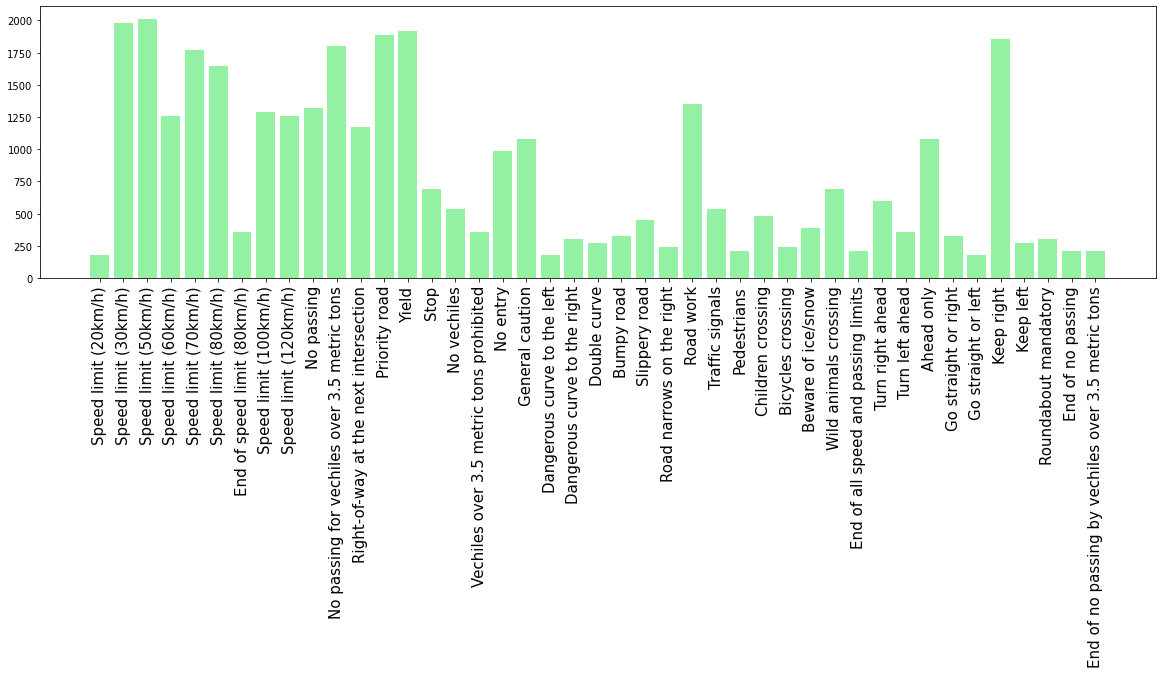

In [8]:
plt.figure(figsize=(20,5))
item, count = np.unique(y_train, return_counts=True)
#names is a list of traffic signs, Remember that we already have a list : signs
names = signnames['SignName']
 
y_pos = np.arange(len(names))
plt.bar(item, count, alpha=0.6, color = (0.3,0.9,0.4,0.6) )

plt.xticks(y_pos, names, fontsize=15, rotation=90)

plt.show()

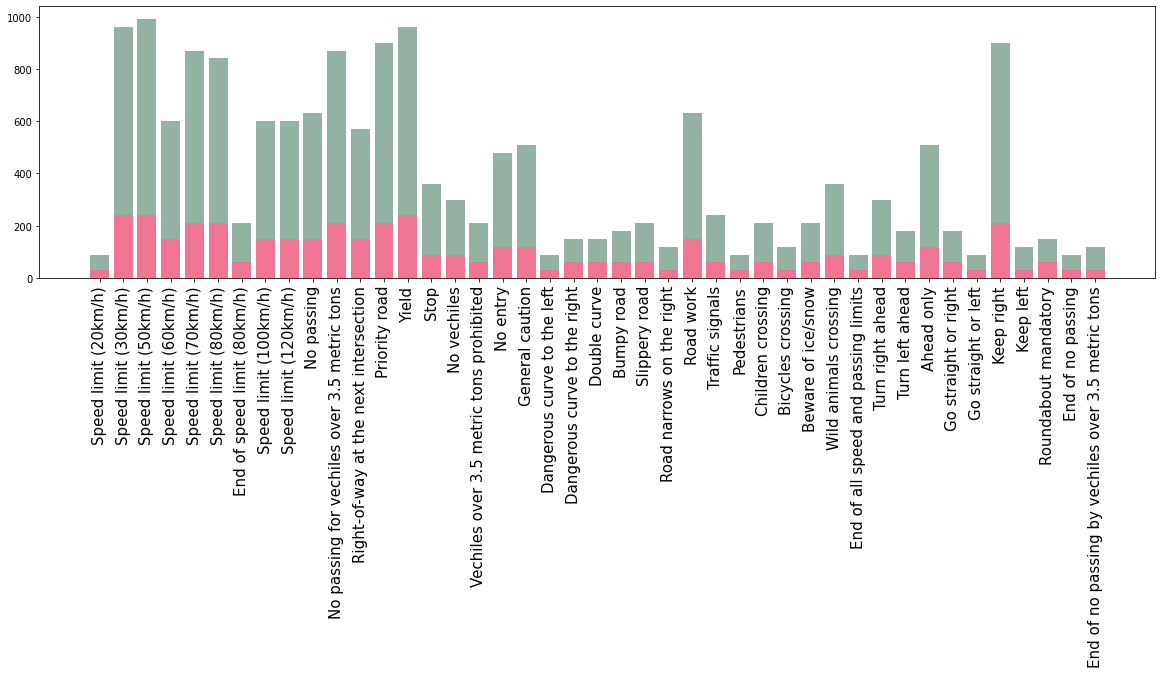

In [9]:
fig = plt.subplots(figsize=(20,5))
item, count = np.unique(y_test, return_counts=True)
item1, count1 = np.unique(y_valid, return_counts=True)

#item, count = signnames['SignName'], y_test.sum()
#item1, count1 = signnames['SignName'], y_valid.sum()

#names is a list of traffic signs, Remember that we already have a list : signs
names = signnames['SignName']
y_pos = np.arange(len(names))

plt.bar(item, count, alpha=0.6, color = (0.3,0.5,0.4,0.2), bottom=count1, label="Train Data" )
plt.bar(item1, count1, alpha=0.6, color = (0.9,0.1,0.3,0.2), label="Validation Data")

plt.xticks(y_pos, names, fontsize=15, rotation=90)

plt.show()

In [10]:
# gray scale
X_test_gry = np.sum(X_test/3, axis=3, keepdims=True)
X_train_gry = np.sum(X_train/3, axis=3, keepdims=True)
X_valid_gry = np.sum(X_valid/3, axis=3, keepdims=True)

In [11]:
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train)

In [12]:
import cv2

def random_translate(img):
    rows,cols,_ = img.shape
    
    # allow translation up to px pixels in x and y directions
    px = 2
    dx,dy = np.random.randint(-px,px,2)

    M = np.float32([[1,0,dx],[0,1,dy]])
    dst = cv2.warpAffine(img,M,(cols,rows))
    
    dst = dst[:,:,np.newaxis]
    
    return dst

Data Augmentation


In [13]:
def random_scaling(img):   
    rows,cols,_ = img.shape

    # transform limits
    px = np.random.randint(-2,2)

    # ending locations
    pts1 = np.float32([[px,px],[rows-px,px],[px,cols-px],[rows-px,cols-px]])

    # starting locations (4 corners)
    pts2 = np.float32([[0,0],[rows,0],[0,cols],[rows,cols]])

    M = cv2.getPerspectiveTransform(pts1,pts2)

    dst = cv2.warpPerspective(img,M,(rows,cols))
    
    dst = dst[:,:,np.newaxis]
    
    return dst

In [14]:
def random_warp(img):
    
    rows,cols,_ = img.shape

    # random scaling coefficients
    rndx = np.random.rand(3) - 0.5
    rndx *= cols * 0.06   # this coefficient determines the degree of warping
    rndy = np.random.rand(3) - 0.5
    rndy *= rows * 0.06

    # 3 starting points for transform, 1/4 way from edges
    x1 = cols/4
    x2 = 3*cols/4
    y1 = rows/4
    y2 = 3*rows/4

    pts1 = np.float32([[y1,x1],
                       [y2,x1],
                       [y1,x2]])
    pts2 = np.float32([[y1+rndy[0],x1+rndx[0]],
                       [y2+rndy[1],x1+rndx[1]],
                       [y1+rndy[2],x2+rndx[2]]])

    M = cv2.getAffineTransform(pts1,pts2)

    dst = cv2.warpAffine(img,M,(cols,rows))
    
    dst = dst[:,:,np.newaxis]
    
    return dst

In [15]:
def random_brightness(img):
    shifted = img + 1.0   # shift to (0,2) range
    img_max_value = max(shifted.flatten())
    max_coef = 2.0/img_max_value
    min_coef = max_coef - 0.1
    coef = np.random.uniform(min_coef, max_coef)
    dst = shifted * coef - 1.0
    return dst

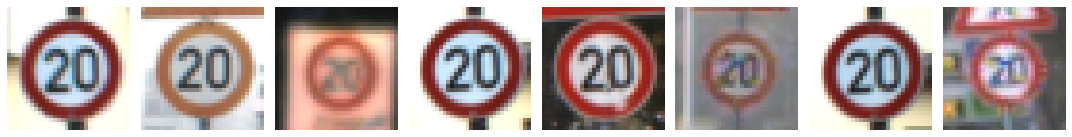

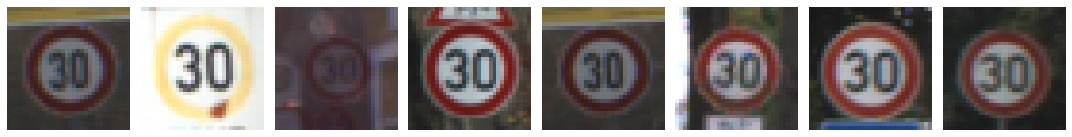

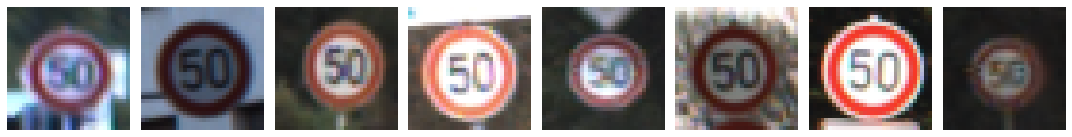

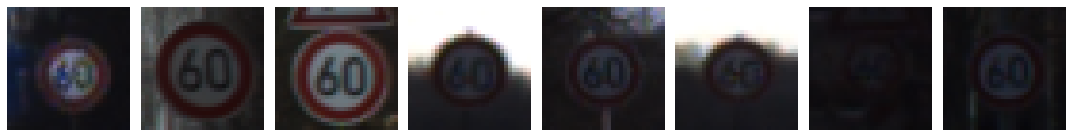

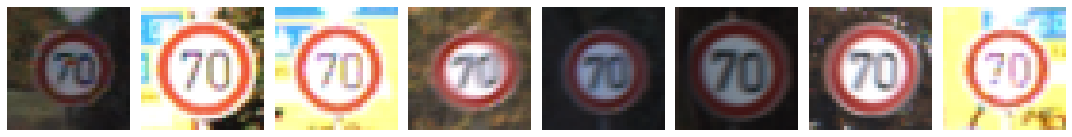

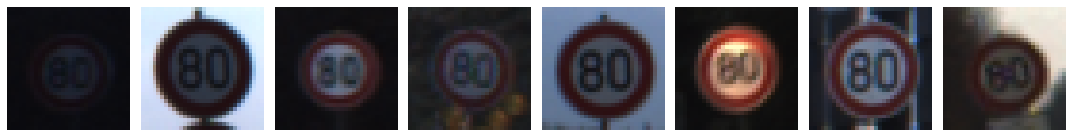

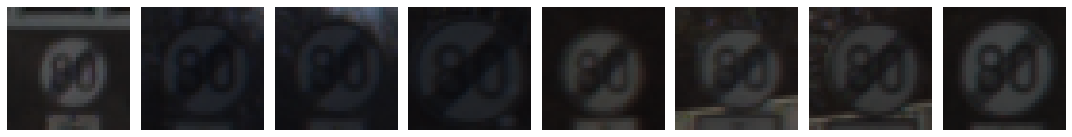

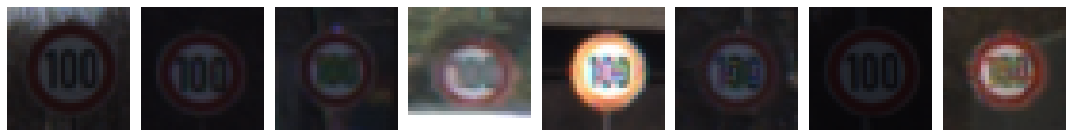

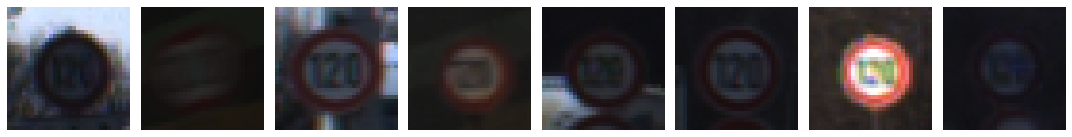

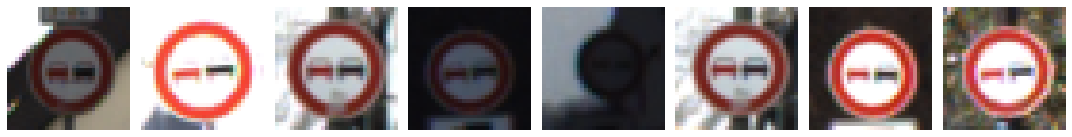

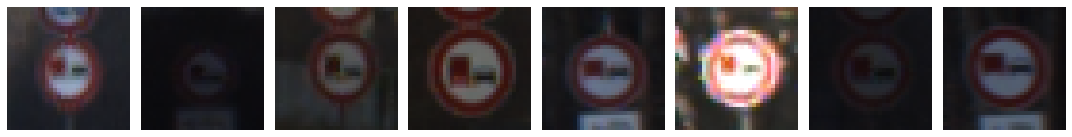

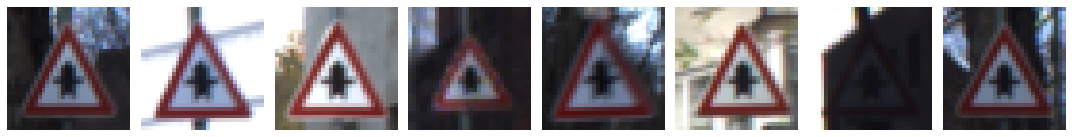

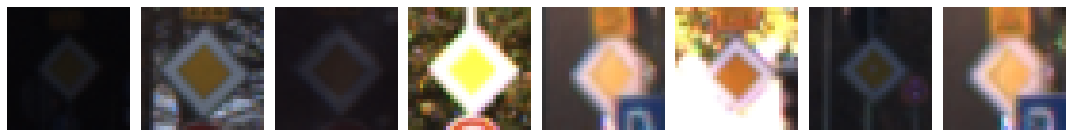

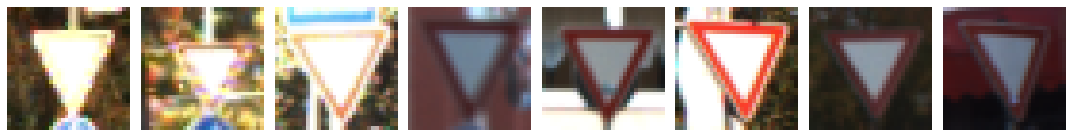

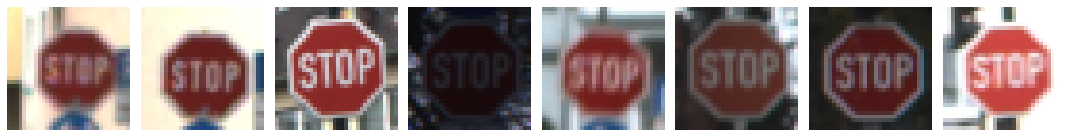

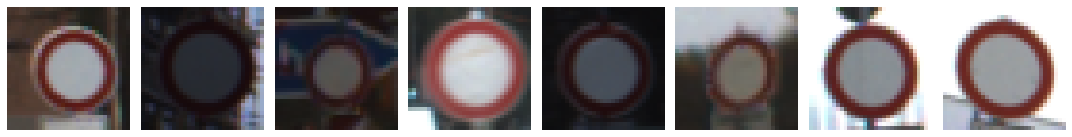

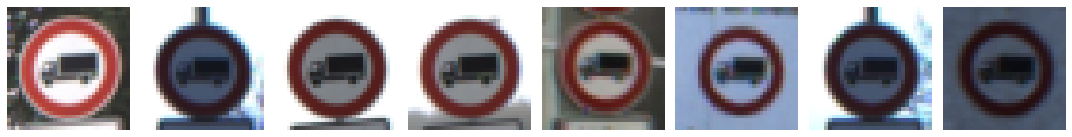

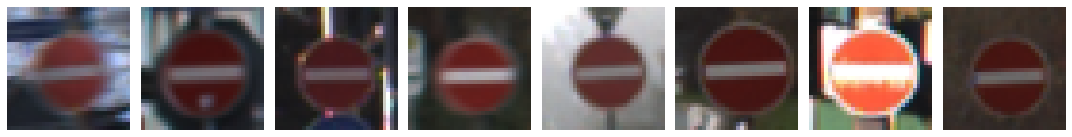

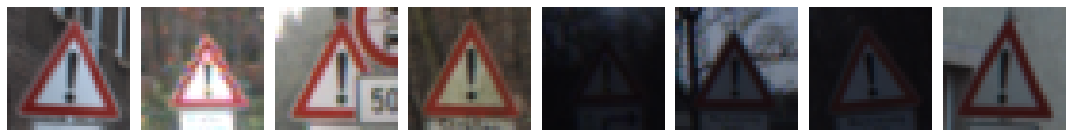

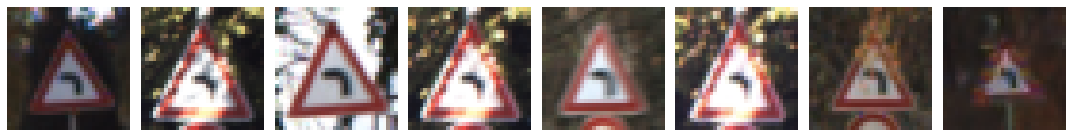

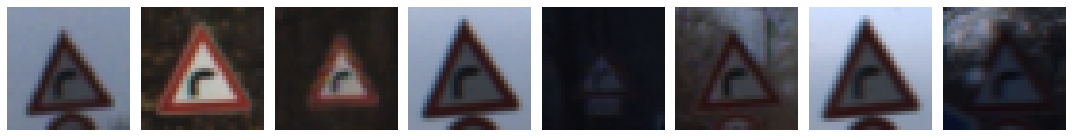

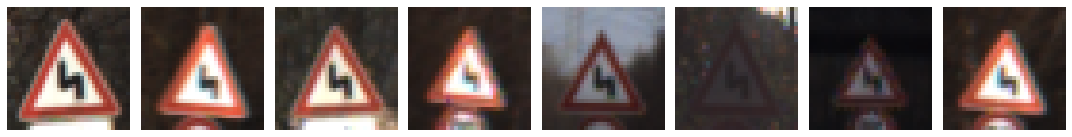

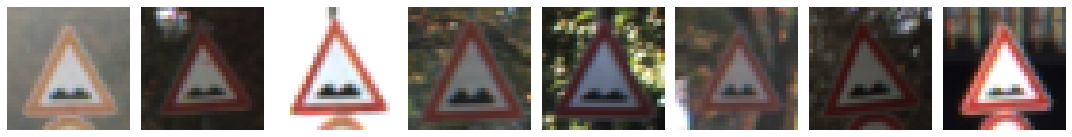

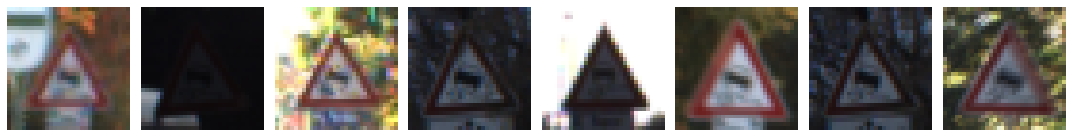

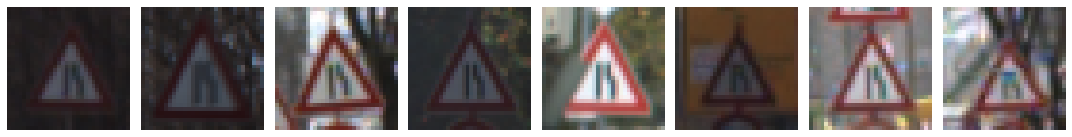

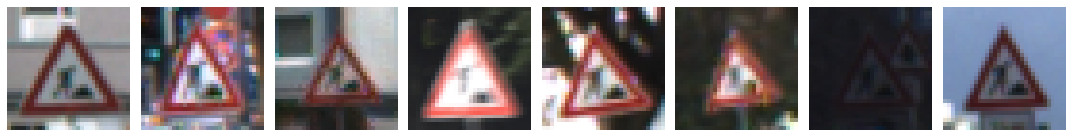

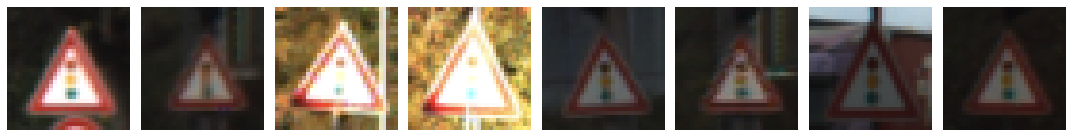

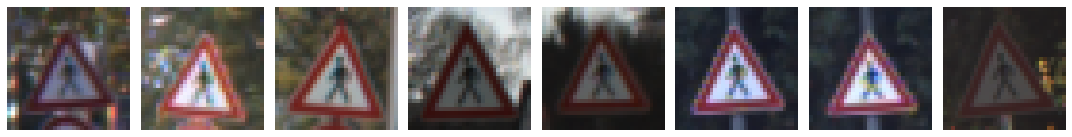

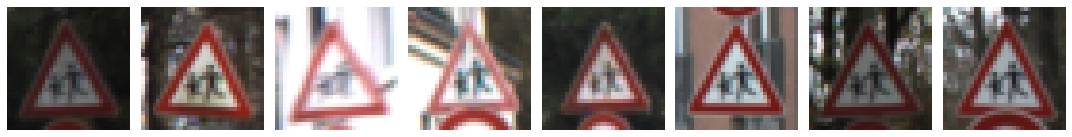

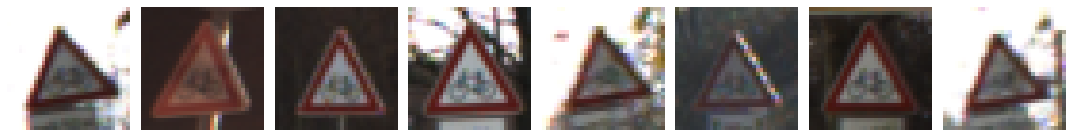

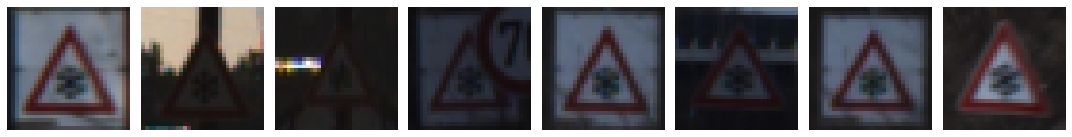

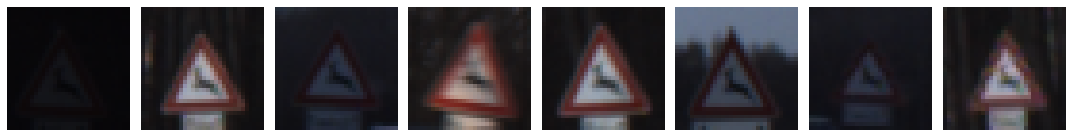

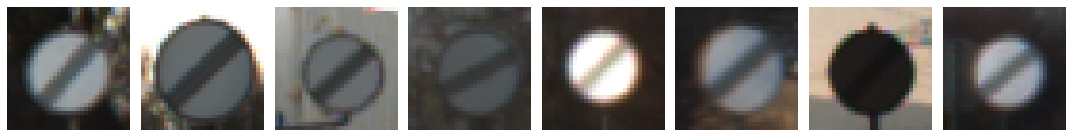

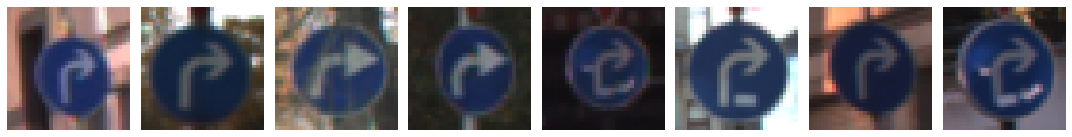

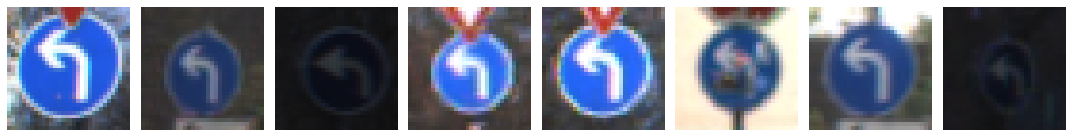

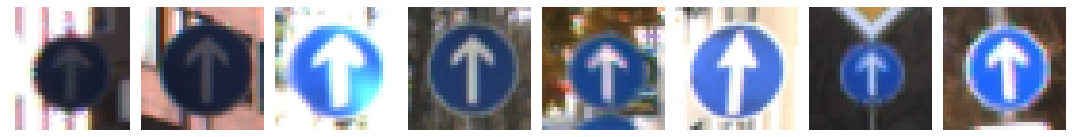

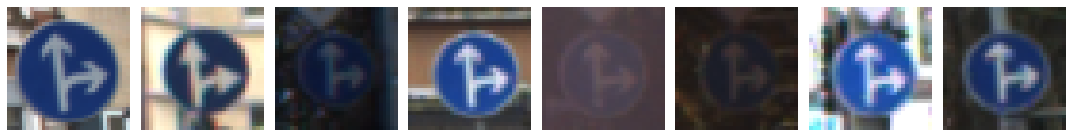

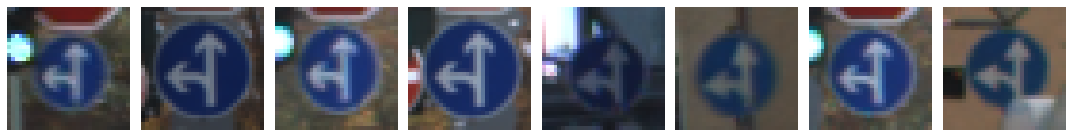

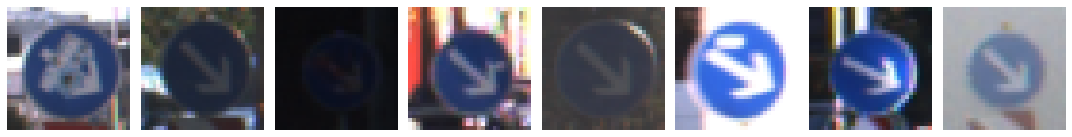

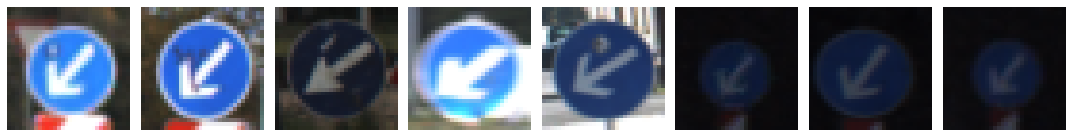

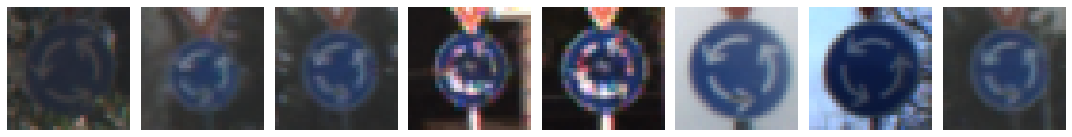

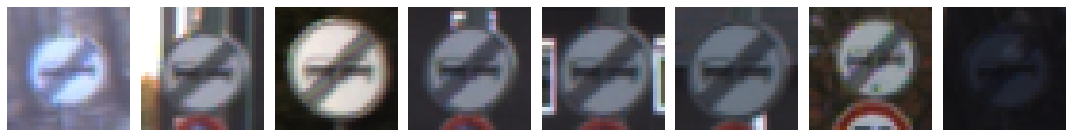

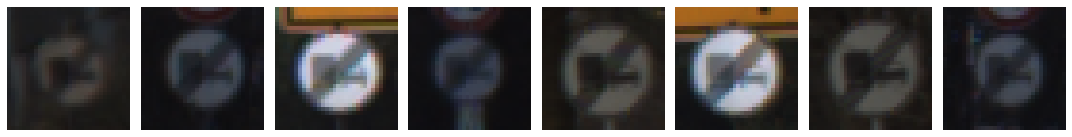

In [16]:
def plot_figures_no_labels(figures, nrows = 1, ncols=1):
    fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(15, 15))
    axs = axs.ravel()
    for index, title in zip(range(len(figures)), figures):
        axs[index].imshow(figures[title], plt.gray())
        axs[index].set_axis_off()
        
    plt.tight_layout()
    plt.show()
    
for class_n in range (43): # you should range for all classes 
  figures = {}

  class_indices = list (np.where(y_train == class_n)[0])
  
  for i in range(8):
    
        figures[i] = X_train[class_indices[-i]].squeeze()
      
  plot_figures_no_labels(figures, 1, 8)

      


### Model Architecture

In [17]:
from keras.models import Sequential
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
model = Sequential([
    Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same',
                     input_shape=(32, 32,3)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),
    Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),
    Conv2D(filters=50, kernel_size=(3,3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2,2)),
    Flatten(),
    # output layer
    Dense(43, activation='sigmoid')
])
model.compile(optimizer='adam', loss='SparseCategoricalCrossentropy', metrics="accuracy")


In [18]:

datagen = ImageDataGenerator(        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

history = model.fit(datagen.flow(X_train,y_train), steps_per_epoch=1000,
                               validation_data=datagen.flow(X_valid,y_valid), validation_steps=len(X_valid), epochs=15, verbose=1)

Epoch 1/15
1000/1000 [==============================] - 67s 35ms/step - loss: 2.1637 - accuracy: 0.3748 - val_loss: 2.7767 - val_accuracy: 0.3363
Epoch 2/15
1000/1000 [==============================] - 30s 30ms/step - loss: 1.0962 - accuracy: 0.6439
Epoch 3/15
1000/1000 [==============================] - 30s 30ms/step - loss: 0.7429 - accuracy: 0.7502
Epoch 4/15
1000/1000 [==============================] - 30s 30ms/step - loss: 0.5600 - accuracy: 0.8132
Epoch 5/15
1000/1000 [==============================] - 30s 30ms/step - loss: 0.4594 - accuracy: 0.8461
Epoch 6/15
1000/1000 [==============================] - 30s 30ms/step - loss: 0.3983 - accuracy: 0.8678
Epoch 7/15
1000/1000 [==============================] - 30s 30ms/step - loss: 0.3457 - accuracy: 0.8847
Epoch 8/15
1000/1000 [==============================] - 30s 30ms/step - loss: 0.3154 - accuracy: 0.8951
Epoch 9/15
1000/1000 [==============================] - 30s 30ms/step - loss: 0.2761 - accuracy: 0.9080
Epoch 10/15
1000/1000 

In [19]:
vgg = VGG16(include_top=False, weights='imagenet', input_shape=(32, 32,3)) 

#we will include weights learned with imagenet dataset
output = vgg.layers[-1].output
output = BatchNormalization()(output)
output = Flatten()(output)
vgg = Model(vgg.input, output)
for layer in vgg.layers:
    layer.trainable = False
# all layers are not trainable

58900480/58889256 [==============================] - 1s 0us/step


In [20]:
from keras import Sequential
from tensorflow.keras.optimizers import Adam
model = Sequential()
model.add(vgg)
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(64))
model.add(Dense(43, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy',optimizer=Adam(learning_rate=0.001),
              metrics=['accuracy'])

In [21]:
history = model.fit_generator(datagen.flow(X_train,y_train), steps_per_epoch=1000,
                              validation_data=datagen.flow(X_valid,y_valid), validation_steps=len(X_valid), epochs=15, verbose=1)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/15
1000/1000 [==============================] - 41s 39ms/step - loss: 2.0589 - accuracy: 0.3897 - val_loss: 2.1117 - val_accuracy: 0.3585
Epoch 2/15
1000/1000 [==============================] - 34s 34ms/step - loss: 1.6274 - accuracy: 0.4848
Epoch 3/15
1000/1000 [==============================] - 35s 35ms/step - loss: 1.5232 - accuracy: 0.5197
Epoch 4/15
1000/1000 [==============================] - 35s 35ms/step - loss: 1.4567 - accuracy: 0.5375
Epoch 5/15
1000/1000 [==============================] - 34s 34ms/step - loss: 1.4107 - accuracy: 0.5497
Epoch 6/15
1000/1000 [==============================] - 34s 34ms/step - loss: 1.3699 - accuracy: 0.5635
Epoch 7/15
1000/1000 [==============================] - 35s 35ms/step - loss: 1.3590 - accuracy: 0.5620
Epoch 8/15
1000/1000 [==============================] - 35s 35ms/step - loss: 1.3412 - accuracy: 0.5646
Epoch 9/15
1000/1000 [==============================] - 35s 35ms/step - loss: 1.3246 - accuracy: 0.5766
Epoch 10/15
1000/1000 

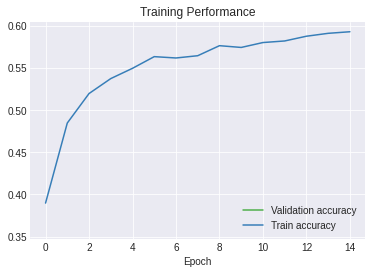

In [26]:
plt.style.use('seaborn-darkgrid')
palette = plt.get_cmap('Set1')

plt.plot(history.history['val_accuracy'], label='Validation accuracy', color = palette(2))
plt.plot(history.history['accuracy'], label='Train accuracy', color = palette(1))
plt.title("Training Performance")
plt.xlabel("Epoch")
plt.legend()
plt.show()
#for some reason val_accuracy is not shown
#pretrained model got accuracy .70 in 150 epochbut note book crashed